In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics

import transformers
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import Trainer,TrainingArguments
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


# TASK 1

In [2]:
train = pd.read_csv(r"C:\Users\Xps\Desktop\UdeS\_NLP\iSarcasmEval-main\train\train.En.csv")
print(train.shape)

(3468, 10)


In [3]:
train.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.isna().sum()

Unnamed: 0                0
tweet                     1
sarcastic                 0
rephrase               2601
sarcasm                2601
irony                  2601
satire                 2601
understatement         2601
overstatement          2601
rhetorical_question    2601
dtype: int64

In [5]:
simple_df = train[["tweet","sarcastic"]]
simple_df

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
3463,The population spike in Chicago in 9 months is...,0
3464,You'd think in the second to last English clas...,0
3465,I’m finally surfacing after a holiday to Scotl...,0
3466,Couldn't be prouder today. Well done to every ...,0


- L'idee de task 1 est de finetune a pre-trained model sur plus de donnees
- en task 2 en fait augmentation, pas de choix !!

In [6]:
simple_df.isna().sum()

tweet        1
sarcastic    0
dtype: int64

In [7]:
simple_df = simple_df.dropna()
simple_df = simple_df.reset_index(drop = True)


In [8]:
simple_df['sarcastic'].value_counts()

0    2600
1     867
Name: sarcastic, dtype: int64

In [9]:
import prog.DataCleaning as dc 

Clean = dc.EnglishTextCleaning()

#### enlever les liens

In [10]:
txt = simple_df['tweet'][63]
print(txt)

sortie = Clean.remove_links(txt)
print(sortie)


What a Race ! #sarcastic #WTF1 https://t.co/zRtL5alnoT
What a Race ! #sarcastic #WTF1 


In [11]:
simple_df['tweet'] = simple_df['tweet'].apply(Clean.remove_links)

#### enlever les hashtags

In [12]:
simple_df = Clean.extract_hashtags(simple_df, 'tweet', 'Hashtags')

simple_df['tweet'] = simple_df['tweet'].apply(Clean.remove_hashtags)

In [13]:
simple_df['Hashtags'].value_counts()

[]                                3087
[#LoveIsland]                        2
[#WTF1]                              2
[#AEWAllOut]                         2
[#Eurovision]                        2
                                  ... 
[#AVFC, #AVLARS]                     1
[#beetwitter, #ecologytwitter]       1
[#AcademicTwitter]                   1
[#psychtoolbox]                      1
[#MontyPythonesqueDisses]            1
Name: Hashtags, Length: 365, dtype: int64

#### enlever les caractères spéciaux 

In [14]:
# Appliquer la fonction remove_special_chars() à la colonne 'Text'
simple_df['tweet'] = simple_df['tweet'].apply(Clean.remove_special_chars)

#### enlever les tabulations \t et new lines \n

In [15]:
simple_df['tweet'] = simple_df['tweet'].apply(Clean.remove_spaces_and_newlines)

#### enlever les emojis

In [16]:
simple_df['Emojis'] = simple_df['tweet'].apply(Clean.extract_emojis)

### Bert model

In [17]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [18]:
import Models.Bert as bert
bb = bert.SarcasmTestDataset()

TypeError: __init__() missing 1 required positional argument: 'encodings'

### Entrainnement du modele en utilisant BertSequenceClassification

In [20]:
train_encodings = bert.tokenizer(train_tweets, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_tweets, padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512)

train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)
test_dataset = SarcasmTestDataset(test_encodings)

training_args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        seed=0,
        load_best_model_at_end=True,
    )

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)

trainer = Trainer(
        model=model, args=training_args, train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.465600,0.786139,0.763689,0.305085


TrainOutput(global_step=585, training_loss=0.4239059040689061, metrics={'train_runtime': 203.0902, 'train_samples_per_second': 46.088, 'train_steps_per_second': 2.88, 'total_flos': 557959881772800.0, 'train_loss': 0.4239059040689061, 'epoch': 3.0})

In [21]:
trainer.evaluate()

{'eval_loss': 0.7861387729644775,
 'eval_accuracy': 0.7636887608069164,
 'eval_f1_score': 0.3050847457627119,
 'eval_runtime': 2.1572,
 'eval_samples_per_second': 160.854,
 'eval_steps_per_second': 10.198,
 'epoch': 3.0}

In [22]:
preds = trainer.predict(test_dataset=test_dataset)
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()

In [57]:
print(predictions.cpu().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

In [23]:
test_tweets = test['text'].values.tolist() 
test_labels = test['sarcastic'].values.tolist() 
test_encodings = tokenizer(test_tweets,
                            truncation=True, 
                            padding=True,
                            return_tensors='pt').to("cuda") 

# Prédiction des étiquettes
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)

# Calcul du score F1
f1 = f1_score(test_labels, predictions.cpu())

print(f"F1 Score: {f1}")

F1 Score: 0.3779527559055118


#### Utilisation de l'embedding de bert pour entrainer un modele ML/DL

In [28]:
train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_tweets, padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512)

In [24]:
trainset = pd.DataFrame({
    "tweet_embedding": train_encodings['input_ids'], #.cpu().numpy().tolist(),
    "label": train_labels
})
print(trainset.shape)
trainset.head()

(3120, 2)


,tweet_embedding,label
0,"[101, 10261, 2035, 1996, 5798, 3348, 2006, 103...",1
1,"[101, 2205, 28987, 3107, 2033, 2046, 8750, 101...",0
2,"[101, 2651, 2001, 1037, 2204, 2154, 100, 1045,...",0
3,"[101, 25818, 4455, 2033, 2006, 2227, 7292, 206...",0
4,"[101, 9358, 15457, 3207, 2074, 2743, 2408, 202...",0


In [25]:
valset = pd.DataFrame({
    "tweet_embedding": val_encodings['input_ids'], #.cpu().numpy().tolist(),
    "label": val_labels
})

print(valset.shape)
valset.head()

(347, 2)


,tweet_embedding,label
0,"[101, 1001, 11338, 14151, 25425, 5092, 23998, ...",0
1,"[101, 2054, 2785, 1997, 15516, 2031, 1061, 152...",1
2,"[101, 1030, 2159, 22517, 26915, 2575, 2683, 20...",0
3,"[101, 2045, 2003, 5621, 2498, 2066, 2026, 2854...",0
4,"[101, 2026, 2643, 1010, 2002, 1521, 1055, 2130...",0


In [75]:
len(testset.iloc[0,0])

146

In [27]:
testset = pd.DataFrame({
    "tweet_embedding": test_encodings['input_ids'].cpu().numpy().tolist(),
    "label": test_labels
})

print(testset.shape)
testset.head()

(1400, 2)


,tweet_embedding,label
0,"[101, 2946, 2006, 1996, 1996, 17209, 2136, 101...",0
1,"[101, 9231, 7384, 999, 102, 0, 0, 0, 0, 0, 0, ...",0
2,"[101, 2061, 1996, 4104, 2231, 2215, 2111, 2000...",1
3,"[101, 12700, 3560, 4013, 5955, 1024, 2689, 199...",0
4,"[101, 1045, 2052, 3058, 2151, 1997, 2122, 2273...",0


In [28]:
trainset.to_csv('/kaggle/working/output/trainset.csv', index=False)
testset.to_csv('/kaggle/working/output/testset.csv', index=False)
valset.to_csv('/kaggle/working/output/valset.csv', index=False)

-> Simple neural network

Epoch 20/100, Train Loss: 0.4192647705880963, Val Loss: 2.618393282095591, Precision: 0.6426512968299711, F1 Score: 0.25738901026423183, Recall: 0.16091954022988506
Epoch 40/100, Train Loss: 0.31830722793024413, Val Loss: 2.4803147315979004, Precision: 0.6801152737752162, F1 Score: 0.26025994486018117, Recall: 0.16091954022988506
Epoch 60/100, Train Loss: 0.27714530895559153, Val Loss: 2.8479283452033997, Precision: 0.6455331412103746, F1 Score: 0.25761932144910865, Recall: 0.16091954022988506
Epoch 80/100, Train Loss: 0.18960868278328252, Val Loss: 2.7865180571873984, Precision: 0.5821325648414986, F1 Score: 0.3412573910944854, Recall: 0.2413793103448276
Epoch 100/100, Train Loss: 0.1856897251338375, Val Loss: 2.731144428253174, Precision: 0.6311239193083573, F1 Score: 0.32449504796069556, Recall: 0.21839080459770116


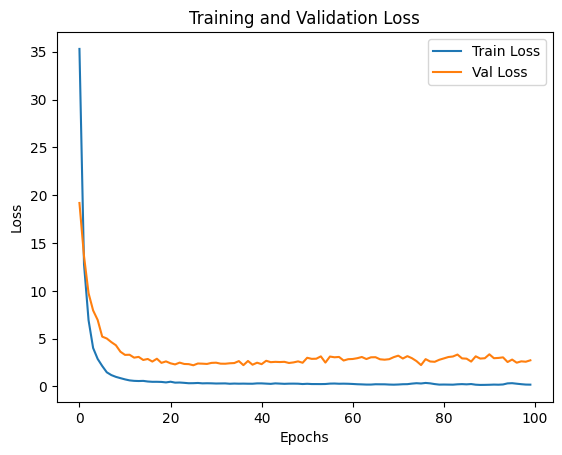

In [144]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
# Préparation des données
X_train = torch.tensor(trainset["tweet_embedding"].tolist(), dtype=torch.float32)
y_train = torch.tensor(trainset["label"].tolist(), dtype=torch.long)
X_val = torch.tensor(valset["tweet_embedding"].tolist(), dtype=torch.float32)
y_val = torch.tensor(valset["label"].tolist(), dtype=torch.long)

zeros = torch.zeros(12)  # Créer un tensor de zéros avec une taille de 2
X_val = torch.cat([X_val, zeros.unsqueeze(0).expand(X_val.size(0), -1)], dim=1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

input_size = 116
hidden_size = 64
output_size = 2  # Nombre de classes
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 100
train_losses = []
val_losses = []
val_precision = []
val_recall = []
val_f1_scores = []
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Évaluation du modèle sur l'ensemble de validation
    model.eval()
    epoch_val_loss = 0.0
    total_correct = 0
    total_samples = 0
    true_positives = 0  # Nombre de vrais positifs
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            true_positives += ((predicted == labels) & (labels == 1)).sum().item()  # Compter les vrais positifs
        
        val_losses.append(epoch_val_loss / len(val_loader))
        
        # Calcul des métriques
        precision = total_correct / total_samples
        recall = true_positives / len(valset[valset["label"] == 1])  # Calcul du rappel
        f1_score = 2 * (precision * recall) / (precision + recall)
        val_precision.append(precision)
        val_recall.append(recall)
        val_f1_scores.append(f1_score)
        
        if (epoch+1)%20==0: 
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Precision: {precision}, F1 Score: {f1_score}, Recall: {recall}")

# Affichage de la courbe de perte
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Préparation des données
X_train = trainset["tweet_embedding"].tolist()
y_train = trainset["label"]
X_val = valset["tweet_embedding"].tolist()
y_val = valset["label"]

# 2. Entraînement du modèle SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)


In [ ]:
# 3. Évaluation du modèle
y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

##### --> Enrichissement des Données: traduction  
##### --> Utilisation de Modèles Multilingues:MBert

##  A faire : 
- data augmentation
- ajout d'un autre modele d'embedding
- tableau de resultats

In [13]:
reddit

,parent_comment,comment,label
0,"Yeah, I get that argument. At this point, I'd ...",NC and NH.,0
1,The blazers and Mavericks (The wests 5 and 6 s...,You do know west teams play against west teams...,0
2,They're favored to win.,"They were underdogs earlier today, but since G...",0
3,deadass don't kill my buzz,"This meme isn't funny none of the ""new york ni...",0
4,Yep can confirm I saw the tool they use for th...,I could use one of those tools.,0
...,...,...,...
1010766,"No one is calling this an engineered pathogen,...",I'm sure that Iran and N. Korea have the techn...,1
1010767,In a move typical of their recent do-nothing a...,"whatever you do, don't vote green!",1
1010768,Screw the Disabled--I've got to get to Church ...,Perhaps this is an atheist conspiracy to make ...,1
1010769,I've always been unsettled by that. I hear a l...,The Slavs got their own country - it is called...,1


In [44]:
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
## Test Dataset
class SarcasmTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred)

    return {"accuracy": accuracy,"f1_score":f1}

def labels(x):
    if x == 0:
        return 0
    else:
        return 1


if __name__ == '__main__':
    path = '/kaggle/input/sarcasm-detection/train.Ar.csv'
    #path_test = '/kaggle/input/sarcasm-detection/task_A_En_test.csv'

    df = pd.read_csv(path)
   # test = pd.read_csv(path_test)
    df = df.dropna(subset=['text'])

    train = df

    train_tweets = train['text'].values.tolist()
    train_labels = train['sarcastic'].values.tolist()
    #test_tweets = test['text'].values.tolist()

    train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_tweets, train_labels, 
                                                                        test_size=0.1,random_state=42,stratify=train_labels)
    model_name = 'detecting-Sarcasm'

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', num_labels=2,
                                            loss_function_params={"weight": [0.75, 0.25]})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [45]:
train_encodings = tokenizer(train_tweets, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_tweets, padding=True, truncation=True, max_length=512)
#test_encodings = tokenizer(test_tweets, padding=True, truncation=True, max_length=512)

train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)
#test_dataset = SarcasmTestDataset(test_encodings)

training_args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        seed=0,
        load_best_model_at_end=True,
    )

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)

trainer = Trainer(
        model=model, args=training_args, train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.384500,0.417408,0.829582,0.662420


TrainOutput(global_step=525, training_loss=0.3787505558558873, metrics={'train_runtime': 210.2532, 'train_samples_per_second': 39.823, 'train_steps_per_second': 2.497, 'total_flos': 666932567015700.0, 'train_loss': 0.3787505558558873, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

In [ ]:
test_tweets = test['text'].values.tolist() 
test_labels = test['sarcastic'].values.tolist() 
test_encodings = tokenizer(test_tweets,
                            truncation=True, 
                            padding=True,
                            return_tensors='pt').to("cuda") 

# Prédiction des étiquettes
with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)

# Calcul du score F1
f1 = f1_score(test_labels, predictions.cpu())

print(f"F1 Score: {f1}")

In [5]:
df = arabe
df

,text,sarcastic
0,ضبط شخص بدبلوم انتحل صفة طبيب بلد مافيش حد فيه...,1
1,مش معنى انك قولتلى رايك يبقى أنا هعمل بيه طب ا...,1
2,اية المهلبية دي يصحبي,1
3,الحديث قياس فيه الفضة و فيه النحاس,1
4,ده فاكر نفسه باشا و بيه كمان,1
...,...,...
3097,احنا اصلا شعب تافه واي حاجه ملهاش لازمه تلاقي ...,0
3098,اول مره اشوف واحد ماعنده الا غمازه واحده شيء غريب,0
3099,تسخايل روحك ذكي أما أنت بوهالي,0
3100,كل شوية امسحى هنا نضفى هنا .. جوزي قارفني و مط...,0


In [6]:
import re
def remove_links(text):
    # Expression régulière pour trouver et enlever les liens
    link_pattern = re.compile(r'http\S+|www\S+')
    return link_pattern.sub(r'', text)

df['text'] = df['text'].apply(remove_links)

In [7]:

def extract_hashtags(df, text_column_name, new_column_name):
    # Create an empty list to store extracted hashtags
    hashtags_list = []
    
    # Regular expression pattern to match hashtags
    hashtag_pattern = r'#\w+'
    
    # Loop through each row in the DataFrame
    for text in df[text_column_name]:
        # Find all hashtags in the text using regular expression
        hashtags = re.findall(hashtag_pattern, text)
        # Append the list of hashtags to the hashtags_list
        hashtags_list.append(hashtags)
    
    # Add the hashtags_list as a new column in the DataFrame
    df[new_column_name] = hashtags_list
    
    return df

def remove_hashtags(text):
    cleaned_text = re.sub(r'#\w+', '', text)
    return cleaned_text



df = extract_hashtags(df, 'text', 'Hashtags')

df['text'] = df['text'].apply(remove_hashtags)

In [9]:
from transformers import AutoTokenizer, AutoModel
DarijaBERT_tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
DarijaBert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")

tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/879k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


pytorch_model.bin:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch


tokenized_texts = []
for text in df['text']:
    tokens = DarijaBERT_tokenizer.tokenize(text)
    indexed_tokens = DarijaBERT_tokenizer.convert_tokens_to_ids(tokens)
    tokens_with_special_tokens = [DarijaBERT_tokenizer.cls_token_id] + indexed_tokens + [DarijaBERT_tokenizer.sep_token_id]
    tokenized_texts.append(torch.tensor(tokens_with_special_tokens))

In [11]:
print(len(tokenized_texts)),print(len(tokenized_texts[0])),print(len(tokenized_texts[45]))


3102
20
17


(None, None, None)

In [12]:
tokens_tensor = pad_sequence(tokenized_texts, batch_first=True, padding_value=DarijaBERT_tokenizer.pad_token_id)
tokens_tensor.size()


torch.Size([3102, 77])

In [13]:
tokens_tensor

tensor([[    2, 41981,  3066,  ...,     0,     0,     0],
        [    2,  2079,  7254,  ...,     0,     0,     0],
        [    2,  5668,  5913,  ...,     0,     0,     0],
        ...,
        [    2, 17550,  3045,  ...,     0,     0,     0],
        [    2,  2044,  2323,  ...,     0,     0,     0],
        [    2,  1996, 77775,  ...,     0,     0,     0]])

In [19]:
with torch.no_grad():
    outputs = DarijaBert_model(tokens_tensor)

In [27]:
outputs

IndexError: tuple index out of range

In [28]:
predictions = process_predictions(test_outputs)

# Évaluation
accuracy = evaluate(predictions, true_labels)

NameError: name 'compute_loss' is not defined

In [41]:
criterion = torch.nn.CrossEntropyLoss()

# Define your optimizer
optimizer = torch.optim.Adam(DarijaBert_model.parameters(), lr=0.001)

# Assuming 'arab' is your DataFrame containing the 'sarcastic' labels
labels = torch.tensor(arabe['sarcastic'].values)

# Assuming 'outputs' is the output from the BERT model
# Example:
# logits = model(outputs.last_hidden_state)

# Calculate the loss
loss = criterion(outputs[1] labels)

# Backpropagation
loss.backward()
optimizer.step()

AttributeError: 'Tensor' object has no attribute 'logits'

In [42]:
outputs[1]

tensor([[-0.3421, -0.2208, -0.0347,  ..., -0.2347, -0.5699, -0.8182],
        [-0.4184, -0.2092, -0.3047,  ..., -0.1337, -0.3379, -0.9302],
        [-0.4380, -0.2327, -0.4925,  ..., -0.2317, -0.3860, -0.8557],
        ...,
        [-0.4606, -0.0375, -0.1249,  ..., -0.4675, -0.5467, -0.9387],
        [-0.5045, -0.2559, -0.0836,  ...,  0.0982, -0.7044, -0.7977],
        [-0.4691, -0.1687, -0.2047,  ..., -0.1335, -0.4464, -0.8404]])

In [36]:
outputs[1]

tensor([[-0.3421, -0.2208, -0.0347,  ..., -0.2347, -0.5699, -0.8182],
        [-0.4184, -0.2092, -0.3047,  ..., -0.1337, -0.3379, -0.9302],
        [-0.4380, -0.2327, -0.4925,  ..., -0.2317, -0.3860, -0.8557],
        ...,
        [-0.4606, -0.0375, -0.1249,  ..., -0.4675, -0.5467, -0.9387],
        [-0.5045, -0.2559, -0.0836,  ...,  0.0982, -0.7044, -0.7977],
        [-0.4691, -0.1687, -0.2047,  ..., -0.1335, -0.4464, -0.8404]])